In [58]:
import torch
import torch.nn as nn
import numpy as np
import json
import glob
import re
from pathlib import Path

def load_weights_to_conv2d(weights_file):
    """
    Load kernel weights and create a PyTorch Conv2d layer.
    
    Parameters:
    -----------
    weights_file : str
        Path to weights file (.json, .npy, or .mem)
        
    Returns:
    --------
    conv_layer : nn.Conv2d
        PyTorch convolution layer with loaded weights
    """
    weights_file = Path(weights_file)
    
    if weights_file.suffix == ".json":
        with open(weights_file, 'r') as f:
            data = json.load(f)
        weights = np.array(data['weights'], dtype=np.float32)
        config = data['config']
        
    elif weights_file.suffix == ".npy":
        weights = np.load(weights_file).astype(np.float32)
        # Infer config from shape
        in_channels, out_channels, kernel_size, _ = weights.shape
        config = {
            'in_channels': in_channels,
            'out_channels': out_channels,
            'kernel_size': kernel_size
        }
        
    elif weights_file.suffix == ".mem":
        # Parse Vivado memory file
        config = {}
        data_lines = []
        
        with open(weights_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('// Input channels:'):
                    config['in_channels'] = int(line.split(':')[1].strip())
                elif line.startswith('// Output channels:'):
                    config['out_channels'] = int(line.split(':')[1].strip())
                elif line.startswith('// Kernel size:'):
                    kernel_info = line.split(':')[1].strip()
                    kernel_size = int(kernel_info.split('x')[0])
                    config['kernel_size'] = kernel_size
                elif line.startswith('// Bits per weight:'):
                    config['bits_per_weight'] = int(line.split(':')[1].strip())
                elif line.startswith('@') and not line.startswith('//'):
                    data_lines.append(line)
        
        # Reconstruct weights from hex data
        in_channels = config['in_channels']
        out_channels = config['out_channels']
        kernel_size = config['kernel_size']
        bits_per_weight = config['bits_per_weight']
        
        weights = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.int32)
        
        for line in data_lines:
            parts = line.split()
            address = int(parts[0][1:], 16)
            hex_data = parts[1]
            packed_value = int(hex_data, 16)
            
            # Decode address
            total_positions = kernel_size * kernel_size
            in_ch = address // total_positions
            pos = address % total_positions
            row = pos // kernel_size
            col = pos % kernel_size
            
            # Unpack weights
            for out_ch in range(out_channels):
                shift = out_ch * bits_per_weight
                mask = (1 << bits_per_weight) - 1
                weight_unsigned = (packed_value >> shift) & mask
                
                # Convert to signed
                if weight_unsigned >= (1 << (bits_per_weight - 1)):
                    weight_signed = weight_unsigned - (1 << bits_per_weight)
                else:
                    weight_signed = weight_unsigned
                    
                weights[in_ch, out_ch, row, col] = weight_signed
        
        weights = weights.astype(np.float32)
    
    else:
        raise ValueError(f"Unsupported file format: {weights_file.suffix}")
    
    # Convert to PyTorch format: [out_channels, in_channels, height, width]
    torch_weights = torch.from_numpy(weights).permute(1, 0, 2, 3)
    
    # Create Conv2d layer
    conv_layer = nn.Conv2d(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        kernel_size=config['kernel_size'],
        stride=1,
        padding=config['kernel_size'] // 2,
        bias=False
    )
    
    # Load weights
    with torch.no_grad():
        conv_layer.weight.copy_(torch_weights)
    
    return conv_layer

import torch
import torch.nn as nn
import numpy as np
import json
import glob
import re
from pathlib import Path

def load_weights_to_conv2d(weights_file):
    """
    Load kernel weights and create a PyTorch Conv2d layer.
    
    Parameters:
    -----------
    weights_file : str
        Path to weights file (.json, .npy, or .mem)
        
    Returns:
    --------
    conv_layer : nn.Conv2d
        PyTorch convolution layer with loaded weights
    """
    weights_file = Path(weights_file)
    
    if weights_file.suffix == ".json":
        with open(weights_file, 'r') as f:
            data = json.load(f)
        weights = np.array(data['weights'], dtype=np.float32)
        config = data['config']
        
    elif weights_file.suffix == ".npy":
        weights = np.load(weights_file).astype(np.float32)
        # Infer config from shape
        in_channels, out_channels, kernel_size, _ = weights.shape
        config = {
            'in_channels': in_channels,
            'out_channels': out_channels,
            'kernel_size': kernel_size
        }
        
    elif weights_file.suffix == ".mem":
        # Parse Vivado memory file
        config = {}
        data_lines = []
        
        with open(weights_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('// Input channels:'):
                    config['in_channels'] = int(line.split(':')[1].strip())
                elif line.startswith('// Output channels:'):
                    config['out_channels'] = int(line.split(':')[1].strip())
                elif line.startswith('// Kernel size:'):
                    kernel_info = line.split(':')[1].strip()
                    kernel_size = int(kernel_info.split('x')[0])
                    config['kernel_size'] = kernel_size
                elif line.startswith('// Bits per weight:'):
                    config['bits_per_weight'] = int(line.split(':')[1].strip())
                elif line.startswith('@') and not line.startswith('//'):
                    data_lines.append(line)
        
        # Reconstruct weights from hex data
        in_channels = config['in_channels']
        out_channels = config['out_channels']
        kernel_size = config['kernel_size']
        bits_per_weight = config['bits_per_weight']
        
        weights = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.int32)
        
        for line in data_lines:
            parts = line.split()
            address = int(parts[0][1:], 16)
            hex_data = parts[1]
            packed_value = int(hex_data, 16)
            
            # Decode address
            total_positions = kernel_size * kernel_size
            in_ch = address // total_positions
            pos = address % total_positions
            row = pos // kernel_size
            col = pos % kernel_size
            
            # Unpack weights
            for out_ch in range(out_channels):
                shift = out_ch * bits_per_weight
                mask = (1 << bits_per_weight) - 1
                weight_unsigned = (packed_value >> shift) & mask
                
                # Convert to signed
                if weight_unsigned >= (1 << (bits_per_weight - 1)):
                    weight_signed = weight_unsigned - (1 << bits_per_weight)
                else:
                    weight_signed = weight_unsigned
                    
                weights[in_ch, out_ch, row, col] = weight_signed
        
        weights = weights.astype(np.float32)
    
    else:
        raise ValueError(f"Unsupported file format: {weights_file.suffix}")
    
    # Convert to PyTorch format: [out_channels, in_channels, height, width]
    torch_weights = torch.from_numpy(weights).permute(1, 0, 2, 3)
    
    # Create Conv2d layer
    conv_layer = nn.Conv2d(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        kernel_size=config['kernel_size'],
        stride=1,
        padding=config['kernel_size'] // 2,
        bias=False
    )
    
    # Load weights
    with torch.no_grad():
        conv_layer.weight.copy_(torch_weights)
    
    return conv_layer

def load_events(events_file, in_channels=4, bits_per_coord=7):
    """
    Load events and return coordinates and individual channel activations.
    
    Parameters:
    -----------
    events_file : str
        Path to events file (.json or .mem)
    in_channels : int
        Number of input channels (for .mem file parsing)
    bits_per_coord : int
        Bits per coordinate (for .mem file parsing)
        
    Returns:
    --------
    coords : np.ndarray
        Array of shape (n_events, 2) with columns [x, y]
    channels : np.ndarray  
        Array of shape (n_events, in_channels) with binary channel activations
    timesteps : np.ndarray
        Array of shape (n_events,) with timestep flags
    """
    events_file = Path(events_file)
    
    if events_file.suffix == ".json":
        with open(events_file, 'r') as f:
            data = json.load(f)
        events_list = data['events']
        in_channels = data['config']['in_channels']
        
        coords = []
        channels = []
        timesteps = []
        
        for event in events_list:
            coords.append([event['x'], event['y']])
            timesteps.append(event['timestep'])
            
            # Convert spike integer to binary channel array
            spike_pattern = event['spikes']
            channel_activations = []
            for ch in range(in_channels):
                channel_activations.append(1 if (spike_pattern & (1 << ch)) else 0)
            channels.append(channel_activations)
        
        return (np.array(coords, dtype=np.int32), 
                np.array(channels, dtype=np.int32),
                np.array(timesteps, dtype=np.int32))
    
    elif events_file.suffix == ".mem":
        # Parse binary event file
        coords = []
        channels = []
        timesteps = []
        
        with open(events_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('//'):
                    # Extract binary data (before any comment)
                    binary_str = line.split()[0]
                    
                    # Parse based on your format: [timestep][x][y][spikes]
                    timestep = int(binary_str[0])
                    x_bits = binary_str[1:1+bits_per_coord]
                    y_bits = binary_str[1+bits_per_coord:1+2*bits_per_coord]
                    spikes_bits = binary_str[1+2*bits_per_coord:]
                    
                    x = int(x_bits, 2)
                    y = int(y_bits, 2)
                    spikes = int(spikes_bits, 2)
                    
                    coords.append([x, y])
                    timesteps.append(timestep)
                    
                    # Convert spike integer to binary channel array
                    channel_activations = []
                    for ch in range(in_channels):
                        channel_activations.append(1 if (spikes & (1 << ch)) else 0)
                    channels.append(channel_activations)
        
        return (np.array(coords, dtype=np.int32),
                np.array(channels, dtype=np.int32), 
                np.array(timesteps, dtype=np.int32))
    
    else:
        raise ValueError(f"Unsupported file format: {events_file.suffix}")
        
def load_memory_dumps(dump_directory=".", bits_per_neuron=9, out_channels=4, pattern="feature_map_mem_*.mem"):
    """
    Load Vivado memory dumps and return signed membrane potential values.
    
    Parameters:
    -----------
    dump_directory : str
        Directory containing memory dump files
    bits_per_neuron : int
        Number of bits per neuron value
    out_channels : int
        Number of output channels (neurons per memory location)
    pattern : str
        Filename pattern for memory dumps
        
    Returns:
    --------
    memory_data : list of np.ndarray
        List of memory dumps, each with shape (memory_depth, out_channels)
        containing signed membrane potential values
    dump_files : list of str
        List of dump filenames in order
    """
    # Find dump files
    search_pattern = str(Path(dump_directory) / pattern)
    dump_files = glob.glob(search_pattern)
    
    if not dump_files:
        raise FileNotFoundError(f"No memory dump files found: {search_pattern}")
    
    # Sort by dump number
    def extract_dump_number(filename):
        match = re.search(r'feature_map_mem_(\d+)\.mem', Path(filename).name)
        return int(match.group(1)) if match else 0
    
    dump_files.sort(key=extract_dump_number)
    
    memory_data = []
    
    for dump_file in dump_files:
        with open(dump_file, 'r') as f:
            lines = f.readlines()
        
        # Remove comments and empty lines
        mem_lines = []
        for line in lines:
            line = line.strip()
            if line and not line.startswith('//'):
                mem_lines.append(line)
        
        # Parse each memory line into multiple neuron values
        dump_array = []
        for mem_line in mem_lines:
            if len(mem_line) > 0:
                # Each memory line contains out_channels packed neurons
                neuron_values = []
                
                for ch in range(out_channels):
                    # Extract bits for this channel
                    start_bit = ch * bits_per_neuron
                    end_bit = start_bit + bits_per_neuron
                    
                    if end_bit <= len(mem_line):
                        # Extract binary substring for this neuron
                        neuron_bits = mem_line[start_bit:end_bit]
                        
                        # Convert to signed integer using two's complement
                        unsigned_val = int(neuron_bits, 2)
                        if unsigned_val >= (1 << (bits_per_neuron - 1)):
                            signed_val = unsigned_val - (1 << bits_per_neuron)
                        else:
                            signed_val = unsigned_val
                        
                        neuron_values.append(signed_val)
                    else:
                        # Handle case where memory line is shorter than expected
                        neuron_values.append(0)
                
                dump_array.append(neuron_values)
        
        memory_data.append(np.array(dump_array, dtype=np.int32))
    
    return memory_data, [Path(f).name for f in dump_files]

In [59]:
kernel_weights_path = r'C:\Users\alext\fenrir\python\conv_test_scripts\kernel_weights.json'
events_path = r'C:\Users\alext\fenrir\python\conv_test_scripts\snn_test_events.json'
memory_dumps_path = r'E:\rtsprojects\general_conv\general_conv.sim\test_all\behav\xsim'

In [60]:
memory_dumps, dump_files = load_memory_dumps(memory_dumps_path, bits_per_neuron=8)
memory_dumps = (np.array(memory_dumps))
memory_dumps.shape, memory_dumps[0].shape, memory_dumps[0][49]

((10, 64, 4), (64, 4), array([0, 0, 0, 0]))

In [61]:
conv_layer = load_weights_to_conv2d(kernel_weights_path)
conv_layer

Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [62]:
coords, channels, timesteps = load_events(events_path)
coords, channels

(array([[5, 1],
        [1, 7],
        [4, 2],
        [6, 7],
        [0, 7],
        [1, 7],
        [7, 0],
        [3, 3],
        [1, 5],
        [1, 1]]),
 array([[0, 1],
        [0, 1],
        [1, 1],
        [1, 0],
        [0, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [0, 1],
        [1, 1]]))

In [63]:
def event_to_tensor(event_idx, coords, channels, img_height, img_width, cumulative=True):
    """
    Convert events up to a specific index to a tensor for Conv2d processing.
    
    Parameters:
    -----------
    event_idx : int
        Index of the last event to include (0-based)
    coords : np.ndarray
        Shape (n_events, 2) with [x, y] coordinates
    channels : np.ndarray  
        Shape (n_events, in_channels) with binary channel activations
    img_height, img_width : int
        Image dimensions
    cumulative : bool
        If True, include all events from 0 to event_idx (default)
        If False, only include the single event at event_idx
        
    Returns:
    --------
    tensor : torch.Tensor
        Shape (1, in_channels, img_height, img_width) with accumulated events
    """
    n_events, in_channels = channels.shape
    
    if event_idx >= n_events or event_idx < 0:
        raise ValueError(f"Event index {event_idx} out of range [0, {n_events-1}]")
    
    # Create empty tensor: batch_size=1, channels, height, width
    tensor = torch.zeros(1, in_channels, img_height, img_width, dtype=torch.float32)
    
    # Determine which events to process
    if cumulative:
        start_idx = 0
        end_idx = event_idx + 1  # Include event_idx
    else:
        start_idx = event_idx
        end_idx = event_idx + 1
    
    # Process events in range
    for i in range(start_idx, end_idx):
        x, y = coords[i]
        
        # Skip if coordinates are out of bounds
        if x < 0 or x >= img_width or y < 0 or y >= img_height:
            continue
            
        # Add active channels for this event
        for ch in range(in_channels):
            if channels[i, ch] == 1:  # Channel is active
                tensor[0, ch, y, x] += 1.0  # Accumulate (count events at each location)
    
    return tensor

In [64]:
event_tensor = event_to_tensor(1, coords, channels, 8, 8, cumulative=True)
event_tensor[0, 0, :, :], event_tensor.shape

(tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([1, 2, 8, 8]))

In [65]:
conv_layer(event_tensor)

tensor([[[[ 0.,  0.,  0.,  0.,  1.,  0., -1.,  0.],
          [ 0.,  0.,  0.,  0.,  2.,  0., -2.,  0.],
          [ 0.,  0.,  0.,  0.,  1.,  0., -1.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
          [ 2.,  0., -2.,  0.,  0.,  0.,  0.,  0.]],

         [[ 0.,  0.,  0.,  0.,  1.,  2.,  1.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0., -1., -2., -1.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        

In [66]:
memd_0 = memory_dumps[1]
memd_0 = memd_0.reshape(8, 8, 4)
memd_0[:,:, 1]

array([[ 0,  0,  0,  0, -1, -2, -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  2,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -2, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [67]:
from matplotlib.patches import Rectangle
def print_comparison(idx):
    # create tensor for event idx
    event_tensor = event_to_tensor(idx, coords, channels, 8, 8, cumulative=True)
    # run conv layer
    conv_output = conv_layer(event_tensor)

    # get memory dump for idx
    mem_dump = memory_dumps[idx]
    # Inverse the channel order for mem_dump to match conv_output
    mem_dump = mem_dump.reshape(8, 8, 4)

    import matplotlib.pyplot as plt

    out_channels = conv_output.shape[1]
    # Determine global vmin/vmax for all images (conv + mem) for consistent color mapping
    vmin = min(conv_output.min().item(), mem_dump.min())
    vmax = max(conv_output.max().item(), mem_dump.max())
    fig, axs = plt.subplots(2, out_channels, figsize=(5 * out_channels, 8))
    if out_channels == 1:
        axs = np.array([[axs[0]], [axs[1]]])
    for ch in range(out_channels):
        # Conv output
        conv_img = conv_output[0, ch, :, :].detach().numpy()
        mem_img = mem_dump[:, :, ch]
        match = np.allclose(conv_img, mem_img)
        color = 'green' if match else 'red'
        # Draw colored border
        for ax in [axs[0, ch], axs[1, ch]]:
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(3)
        im0 = axs[0, ch].imshow(conv_img, cmap='Wistia', interpolation='nearest', vmin=vmin, vmax=vmax)
        axs[0, ch].set_title(f'Conv Output Channel {ch}\nMatch: {match}', color=color)
        axs[0, ch].axis('off')
        plt.colorbar(im0, ax=axs[0, ch], fraction=0.046, pad=0.04)
        # Print values
        for i in range(conv_img.shape[0]):
            for j in range(conv_img.shape[1]):
                val = conv_img[i, j]
                axs[0, ch].text(j, i, f"{val:.0f}", ha='center', va='center', color='black', fontsize=8)
        # Mem dump
        im1 = axs[1, ch].imshow(mem_img, cmap='Wistia', interpolation='nearest', vmin=vmin, vmax=vmax)
        axs[1, ch].set_title(f'Mem Dump Channel {ch}', color=color)
        axs[1, ch].axis('off')
        plt.colorbar(im1, ax=axs[1, ch], fraction=0.046, pad=0.04)
        for i in range(mem_img.shape[0]):
            for j in range(mem_img.shape[1]):
                val = mem_img[i, j]
                axs[1, ch].text(j, i, f"{val}", ha='center', va='center', color='black', fontsize=8)
    plt.tight_layout()
    plt.show()


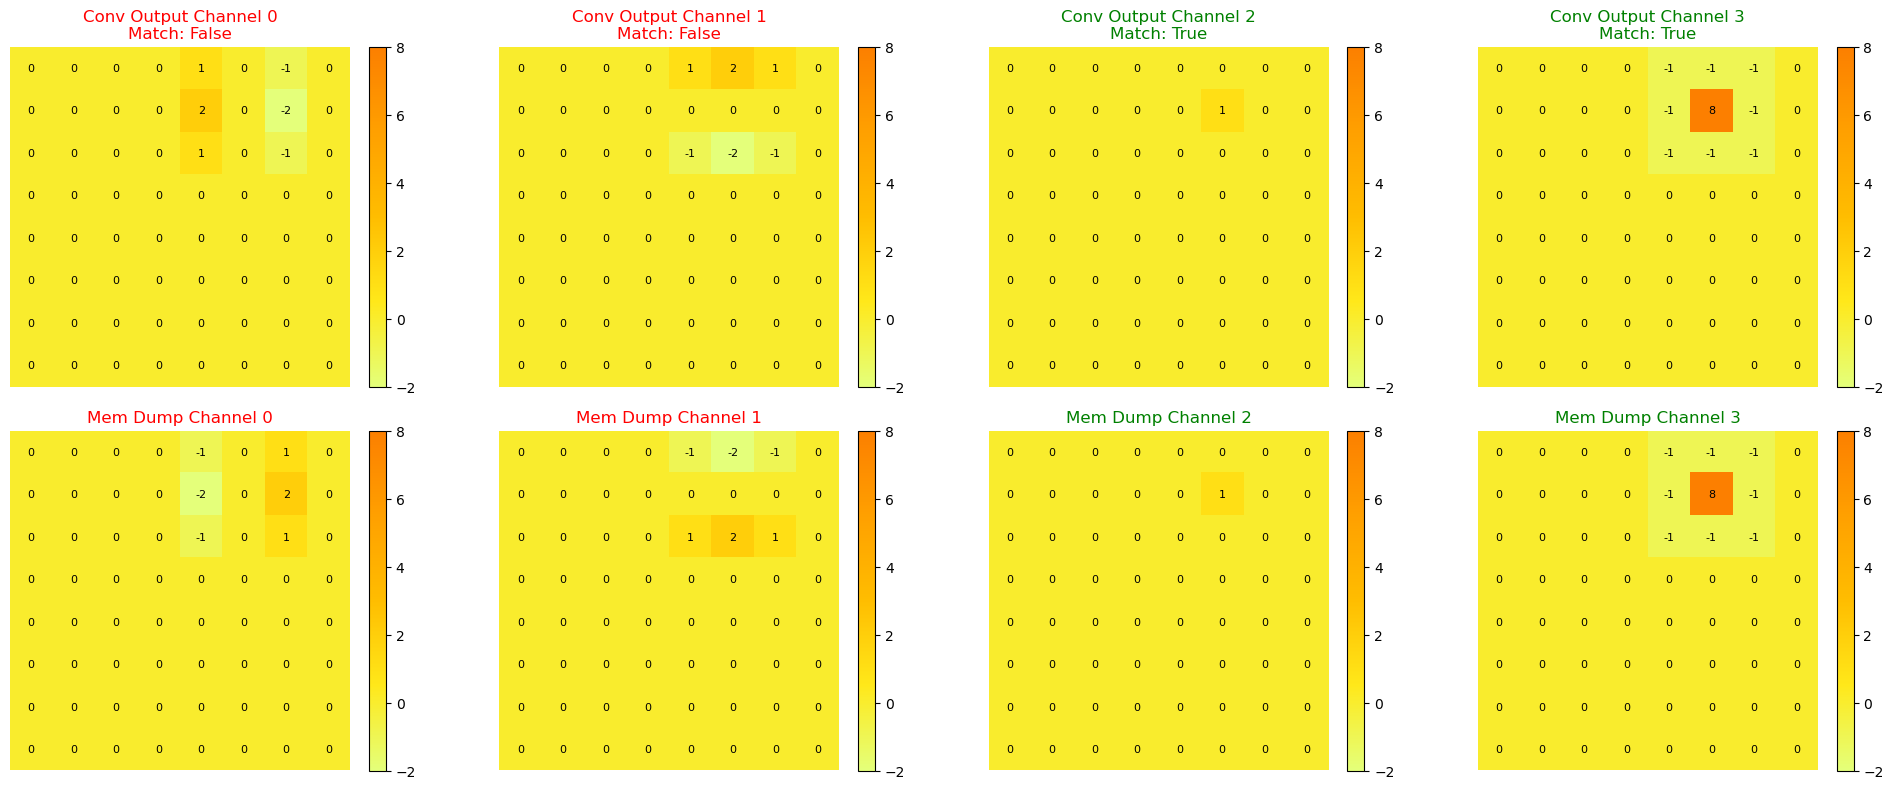

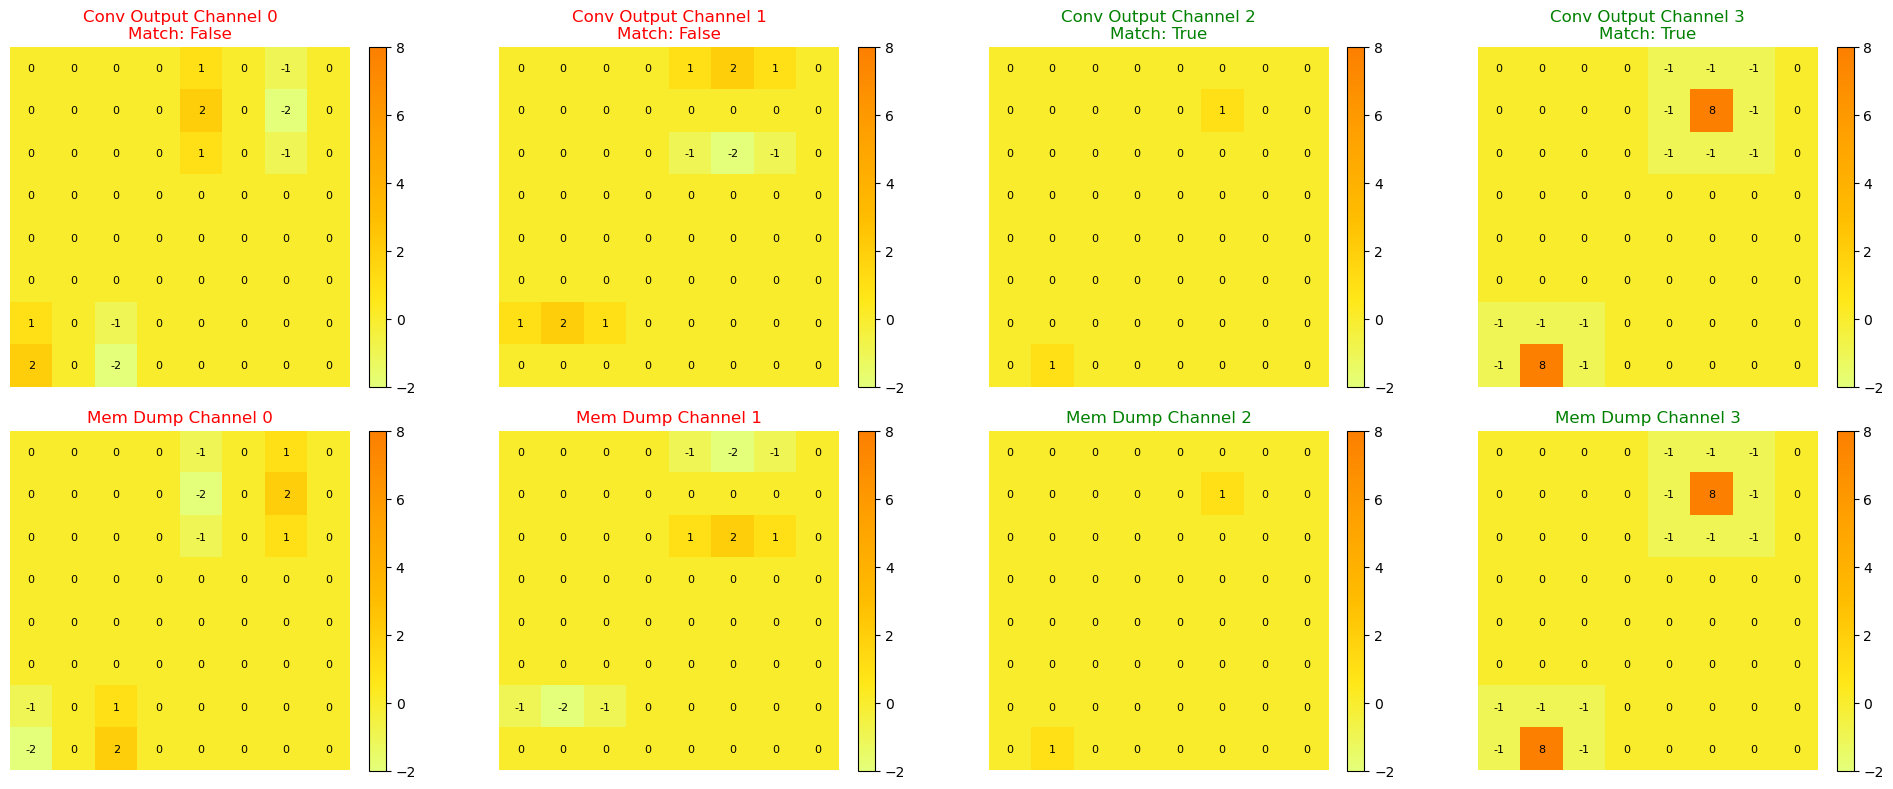

coords [5 1] [1 7]
channels [0 1] [0 1]


In [74]:
idx = 0
print_comparison(idx)
print_comparison(idx + 1)
print("coords", coords[idx], coords[idx + 1])
print("channels", channels[idx], channels[idx + 1])

# DEBUG WITH CLAUDE

In [69]:
# Create tensor for first 3 events (cumulative)
tensor_3_events = event_to_tensor(3, coords, channels, 8, 8)
print("PyTorch tensor shape:", tensor_3_events.shape)

# Check specific locations
print("At (6,1):", tensor_3_events[0, :, 6, 1])  # Event 2 location
print("At (0,7):", tensor_3_events[0, :, 0, 7])  # Event 3 location

PyTorch tensor shape: torch.Size([1, 2, 8, 8])
At (6,1): tensor([0., 0.])
At (0,7): tensor([0., 0.])


In [70]:
# Hardware memory after 3 events
hw_mem = memory_dumps[3].reshape(8, 8, 4)[:, :, ::-1]  # Channel flip
print("HW at (6,1):", hw_mem[6, 1, :])  # Compare with PyTorch
print("HW at (0,7):", hw_mem[0, 7, :])  # Compare with PyTorch

HW at (6,1): [-1  0 -2  0]
HW at (0,7): [0 0 0 0]


In [76]:
event_tensor = event_to_tensor(1, coords, channels, 8, 8, cumulative=True)
    # run conv layer
conv_output = conv_layer(event_tensor)
mem2 = memory_dumps[1].reshape(8, 8, 4)

mem2[:, :, 2], mem2[:, :, 3], conv_output[0, 2, :, :].detach().numpy(), conv_output[0, 3, :, :].detach().numpy()


(array([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0]]),
 array([[ 0,  0,  0,  0, -1, -1, -1,  0],
        [ 0,  0,  0,  0, -1,  8, -1,  0],
        [ 0,  0,  0,  0, -1, -1, -1,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [-1, -1, -1,  0,  0,  0,  0,  0],
        [-1,  8, -1,  0,  0,  0,  0,  0]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[ 0.,  0.,  0.,  0., -1., -

In [72]:
# Check the actual kernel weights
print("Kernel weights for problematic channels:")
with torch.no_grad():
    weights = conv_layer.weight
    print("Channel 2 kernel:\n", weights[2, :, :, :])
    print("Channel 3 kernel:\n", weights[3, :, :, :])

Kernel weights for problematic channels:
Channel 2 kernel:
 tensor([[[0., 0., 0.],
         [0., 1., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 1., 0.],
         [0., 0., 0.]]], requires_grad=True)
Channel 3 kernel:
 tensor([[[ 0., -1.,  0.],
         [-1.,  5., -1.],
         [ 0., -1.,  0.]],

        [[-1., -1., -1.],
         [-1.,  8., -1.],
         [-1., -1., -1.]]], requires_grad=True)


In [73]:
kernel_data = json.load(open(r'C:\Users\alext\fenrir\python\conv_test_scripts\kernel_weights.json'))
weights_array = np.array(kernel_data['weights'])  # Shape: [in_ch, out_ch, row, col]

print("Original kernel weights from file:")
print("Channel 2 (out_ch=2) kernels:")
for in_ch in range(4):
    print(f"  Input ch {in_ch} -> Output ch 2:")
    print(f"    {weights_array[in_ch, 2, :, :]}")

print("\nChannel 3 (out_ch=3) kernels:")  
for in_ch in range(4):
    print(f"  Input ch {in_ch} -> Output ch 3:")
    print(f"    {weights_array[in_ch, 3, :, :]}")

Original kernel weights from file:
Channel 2 (out_ch=2) kernels:
  Input ch 0 -> Output ch 2:
    [[0 0 0]
 [0 1 0]
 [0 0 0]]
  Input ch 1 -> Output ch 2:
    [[0 0 0]
 [0 1 0]
 [0 0 0]]
  Input ch 2 -> Output ch 2:


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
# Look at specific addresses that should contain negative weights
# Let's check a few key negative values:

print("Checking specific negative weight encodings:")
print("Looking for these negative values in .mem file:")
print("  -1 (appears frequently)")
print("  -2 (from input ch 2 -> output ch 2)")
print("  +5 (positive reference)")
print("  +8 (positive reference)")

# Check what the .mem file actually contains for these addresses
with open(r'C:\Users\alext\fenrir\python\conv_test_scripts\kernel_weights.mem', 'r') as f:
    lines = f.readlines()

# Look for addresses that should have negative weights
# Address = in_ch * 9 + position
# For example: in_ch=0, pos=1 (top-middle) should have -1 for out_ch=2

target_addresses = [
    (0 * 9 + 1, "in_ch=0, pos=1 (top-mid): should have -1 for out_ch=2"),
    (0 * 9 + 4, "in_ch=0, pos=4 (center): should have +5 for out_ch=2"), 
    (2 * 9 + 3, "in_ch=2, pos=3 (mid-left): should have -2 for out_ch=2"),
]

for addr, description in target_addresses:
    for line in lines:
        if line.startswith(f'@{addr:03X}'):
            hex_data = line.split()[1]
            packed_value = int(hex_data, 16)
            print(f"\nAddress {addr} ({description}):")
            print(f"  Hex: {hex_data}")
            print(f"  Packed: {packed_value}")
            
            # Unpack each output channel
            for out_ch in range(4):
                shift = out_ch * 6  # 6 bits per weight
                mask = (1 << 6) - 1
                weight_unsigned = (packed_value >> shift) & mask
                
                # Convert to signed
                if weight_unsigned >= 32:  # 2^5 = 32 (sign bit for 6-bit)
                    weight_signed = weight_unsigned - 64  # 2^6 = 64
                else:
                    weight_signed = weight_unsigned
                    
                print(f"    Out_ch {out_ch}: {weight_unsigned:02d} -> {weight_signed:+3d}")
            break

Checking specific negative weight encodings:
Looking for these negative values in .mem file:
  -1 (appears frequently)
  -2 (from input ch 2 -> output ch 2)
  +5 (positive reference)
  +8 (positive reference)

Address 1 (in_ch=0, pos=1 (top-mid): should have -1 for out_ch=2):
  Hex: FC0FC0
  Packed: 16519104
    Out_ch 0: 00 ->  +0
    Out_ch 1: 63 ->  -1
    Out_ch 2: 00 ->  +0
    Out_ch 3: 63 ->  -1

Address 4 (in_ch=0, pos=4 (center): should have +5 for out_ch=2):
  Hex: 141201
  Packed: 1315329
    Out_ch 0: 01 ->  +1
    Out_ch 1: 08 ->  +8
    Out_ch 2: 01 ->  +1
    Out_ch 3: 05 ->  +5

Address 21 (in_ch=2, pos=3 (mid-left): should have -2 for out_ch=2):
  Hex: 03EFC0
  Packed: 257984
    Out_ch 0: 00 ->  +0
    Out_ch 1: 63 ->  -1
    Out_ch 2: 62 ->  -2
    Out_ch 3: 00 ->  +0


In [ ]:
# Load the weights and check the exact same address that's wrong
conv_layer = load_weights_to_conv2d(kernel_weights_path)
weights = conv_layer.weight.detach().numpy()

# Address @013: in_ch=2, pos=(0,1) -> row=0, col=1
# Hardware shows: [-1, 0, 0, -2] for output channels [0,1,2,3]
# Let's see what PyTorch has for the same position

print("PyTorch weights for position (0,1):")
for out_ch in range(4):
    # PyTorch format: [out_channels, in_channels, height, width]
    pytorch_weight = weights[out_ch, 2, 0, 1]  # out_ch, in_ch=2, row=0, col=1
    print(f"  Output ch {out_ch}: {pytorch_weight}")

print("\nHardware weights for same position: [-1, 0, 0, -2]")

PyTorch weights for position (0,1):
  Output ch 0: 0.0
  Output ch 1: -1.0
  Output ch 2: 0.0
  Output ch 3: -2.0

Hardware weights for same position: [-1, 0, 0, -2]
